In [1]:
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.decomposition
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

matplotlib.rcParams['figure.figsize'] = (20,5)

# HW7: Hello Convolutional Networks

Machine learning has transformed our world. It makes perfect sense you all are interested in how to apply machine learning towards big interesting problems! I hope we get a chance to do that in the remainder of this class.

Machine learning is sometimes called out as "statistics for engineers", and I think it's not too far from the truth. To become proficient in ML you best get hands-on engineering experience, in manipulating data, training algorithms, measuring performance and experiencing over/underfitting first hand.

In this exercise we will practice some simple ML approaches we've seen in class using **Scikit-Learn** - a wonderful python package for machine learning and probably the foremost tool for data scientists today. We will also use **Keras** - the high-level API for Google's **Tensorflow**, a leading machine learning package, to build and train neural networks.

There's a great debate on which is the best ML framework. Some think it's Facebook's (before they became Meta) **PyTorch** (which is a Python port of Torch, written in Lua). But there are many, many, many more. Some well known ones are **ONNX** (Microsoft), **OpenVino** (Intel), **MXNet** (Amazon). They are all pretty much the same, and so it comes down to personal preference.

The beginning of the notebook are cells I provided with some instruction on the different APIs we will use.
Follow them, and copy code from them to get you work done in the rest of the notebook.

To start, being computer vision engineers, we will use the **MNIST** hand written digits recognition task. A "Hello World" for computer vision machine learning. Images in this dataset are just $28\times 28$ grayscale pixels.

Here's a sample of the dataset:

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

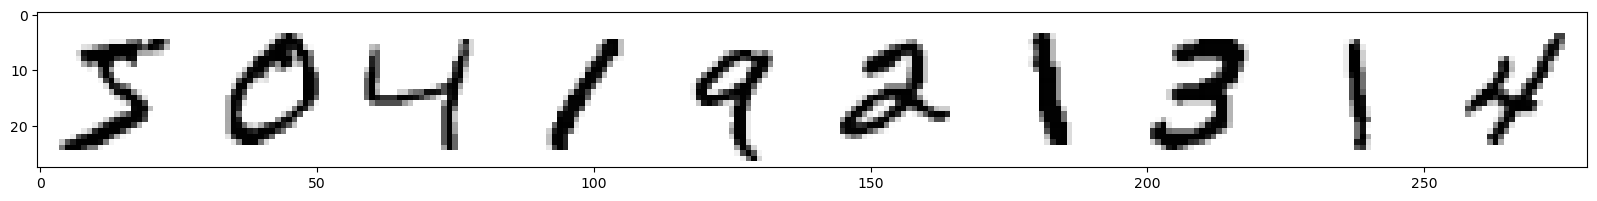

In [3]:
plt.imshow(np.hstack(x_train[:10]), cmap=matplotlib.cm.binary, interpolation='nearest')

All the samples in the (test) set flattened as columns:

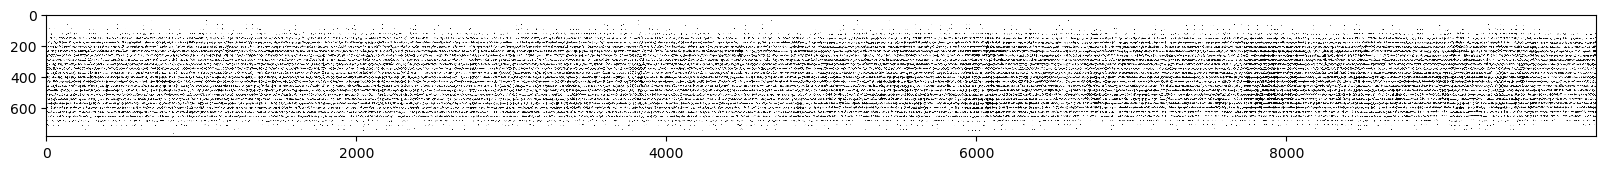

In [4]:
plt.imshow(x_test.reshape(-1, 28*28).T, cmap=matplotlib.cm.binary, interpolation='nearest');

Mean and standard deviation in each pixel:

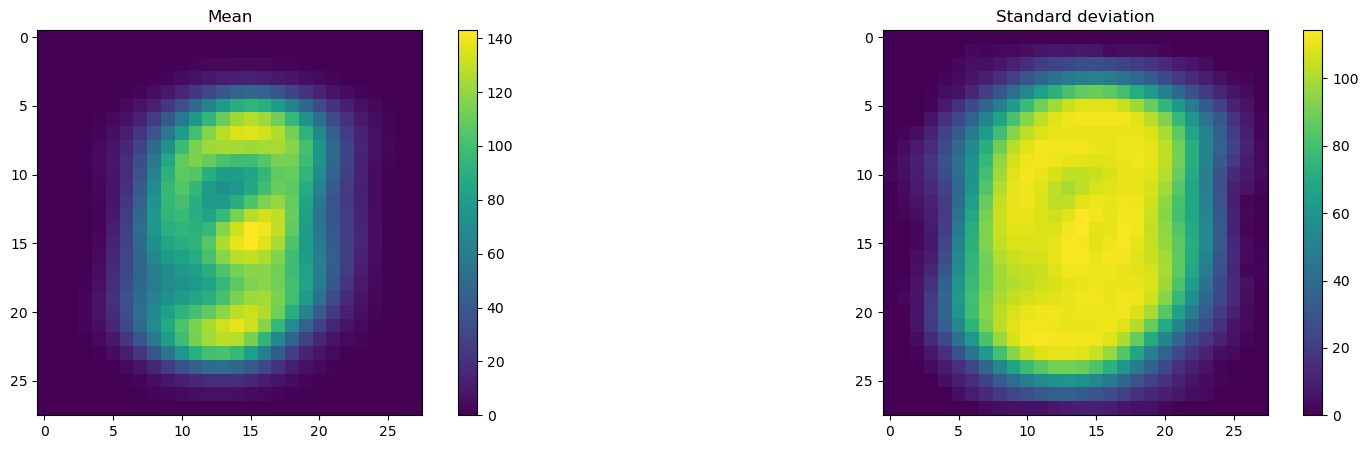

In [5]:
plt.subplot(121),plt.imshow(np.mean(x_test, axis=0)),plt.title("Mean"),plt.colorbar();
plt.subplot(122),plt.imshow(np.std(x_test, axis=0)),plt.title("Standard deviation"),plt.colorbar();

The problem with working with images is that the dimensions are big (here it's 784) and therefore it's hard to visualize. Think about working with images not $28\times28$ but $512\times512$ or even $2048\times2048$! This is not uncommon in computer vision to work in these dimesions.

Sometimes to gain insight to image data we can apply PCA to extarct cross-correlation between features (pixels?).

This will tell us how pixels behave together:

In [6]:
mnist_pca = sklearn.decomposition.PCA().fit(x_test.reshape(-1, 28*28))

Show the first 10 principal components:

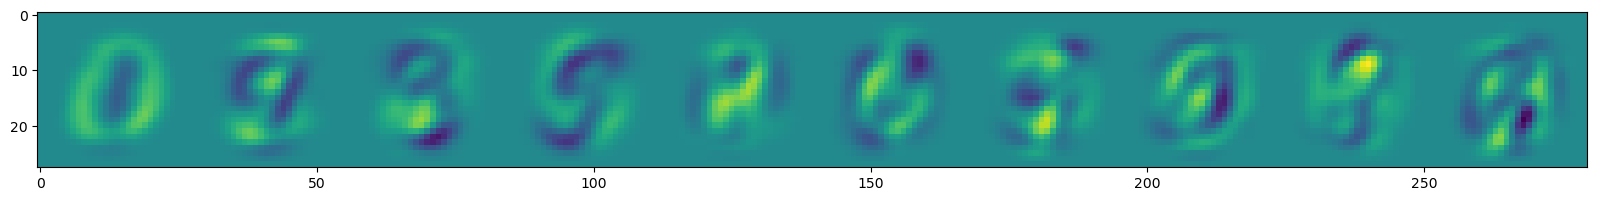

In [7]:
plt.imshow(np.hstack(mnist_pca.components_.reshape(784,28,28)[:10]));

We can see an oval shape is the most prominent direction of change in all digits.

In [8]:
# Scale the data to [0, 1] to work with linear classifiers
x_train = x_train / 255.0
x_test = x_test / 255.0

In MNIST the goal is to predict the written digit, which is a classification problem.

How about the disrtibution of categories in our dataset?

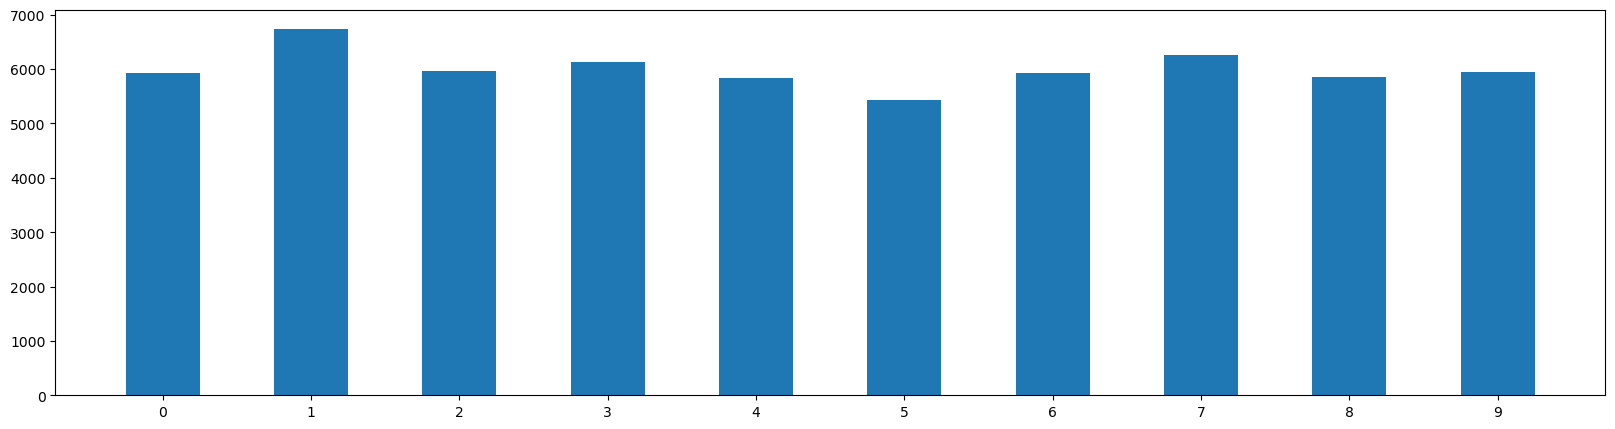

In [9]:
h = np.bincount(y_train)
plt.bar(range(10), h, width=0.5),plt.xticks(range(10));

Seems we have many more '1's than '5's, for example. :shrug: As long as it's not very unbalanced - we should do just fine.

## Regression and Classification

Let's build a binary '3' regressor, i.e. which will tell us "how much a '3' is this digit?". This is a job well suited for Logistic Regression.

In [10]:
y_train_3 = np.int32(y_train == 3) # set all 3s to 1, and all else to 0
y_test_3 = np.int32(y_test == 3)   

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
logreg = LogisticRegression(max_iter=1000)

In [13]:
logreg.fit(x_train.reshape(-1,784), y_train_3)

LogisticRegression(max_iter=1000)

Mmmm, that took a very long time!!

As you remember calculating the regression over the full batch of data (60K) is a very heavy.

In [14]:
# how many iterations did it take?
logreg.n_iter_

array([352], dtype=int32)

In [15]:
# get the predictions on the test set to compare later
y_pred_logreg = logreg.predict(x_test.reshape(-1,784))

We can use minibatch or **stochastic gradient descent** to do the work in a fraction of the time.

In [16]:
from sklearn.linear_model import SGDClassifier

This will create an SGD logistic regressor, however it has built-in a *classification* mechanism with an optimal decision boundary.

In [17]:
logreg_sgd = SGDClassifier(loss='log_loss', max_iter=20, tol=None, random_state=42)

In [18]:
logreg_sgd.fit(x_train.reshape(-1,784), y_train_3)

SGDClassifier(loss='log_loss', max_iter=20, random_state=42, tol=None)

In [19]:
# how many iterations did it take?
logreg_sgd.n_iter_

20

Only 20 iterations for the SGD iterative classifier. Let's compare the results between the two models.

Here are some predictions from the model:

In [20]:
y_pred = logreg_sgd.predict(x_test.reshape(-1,784))

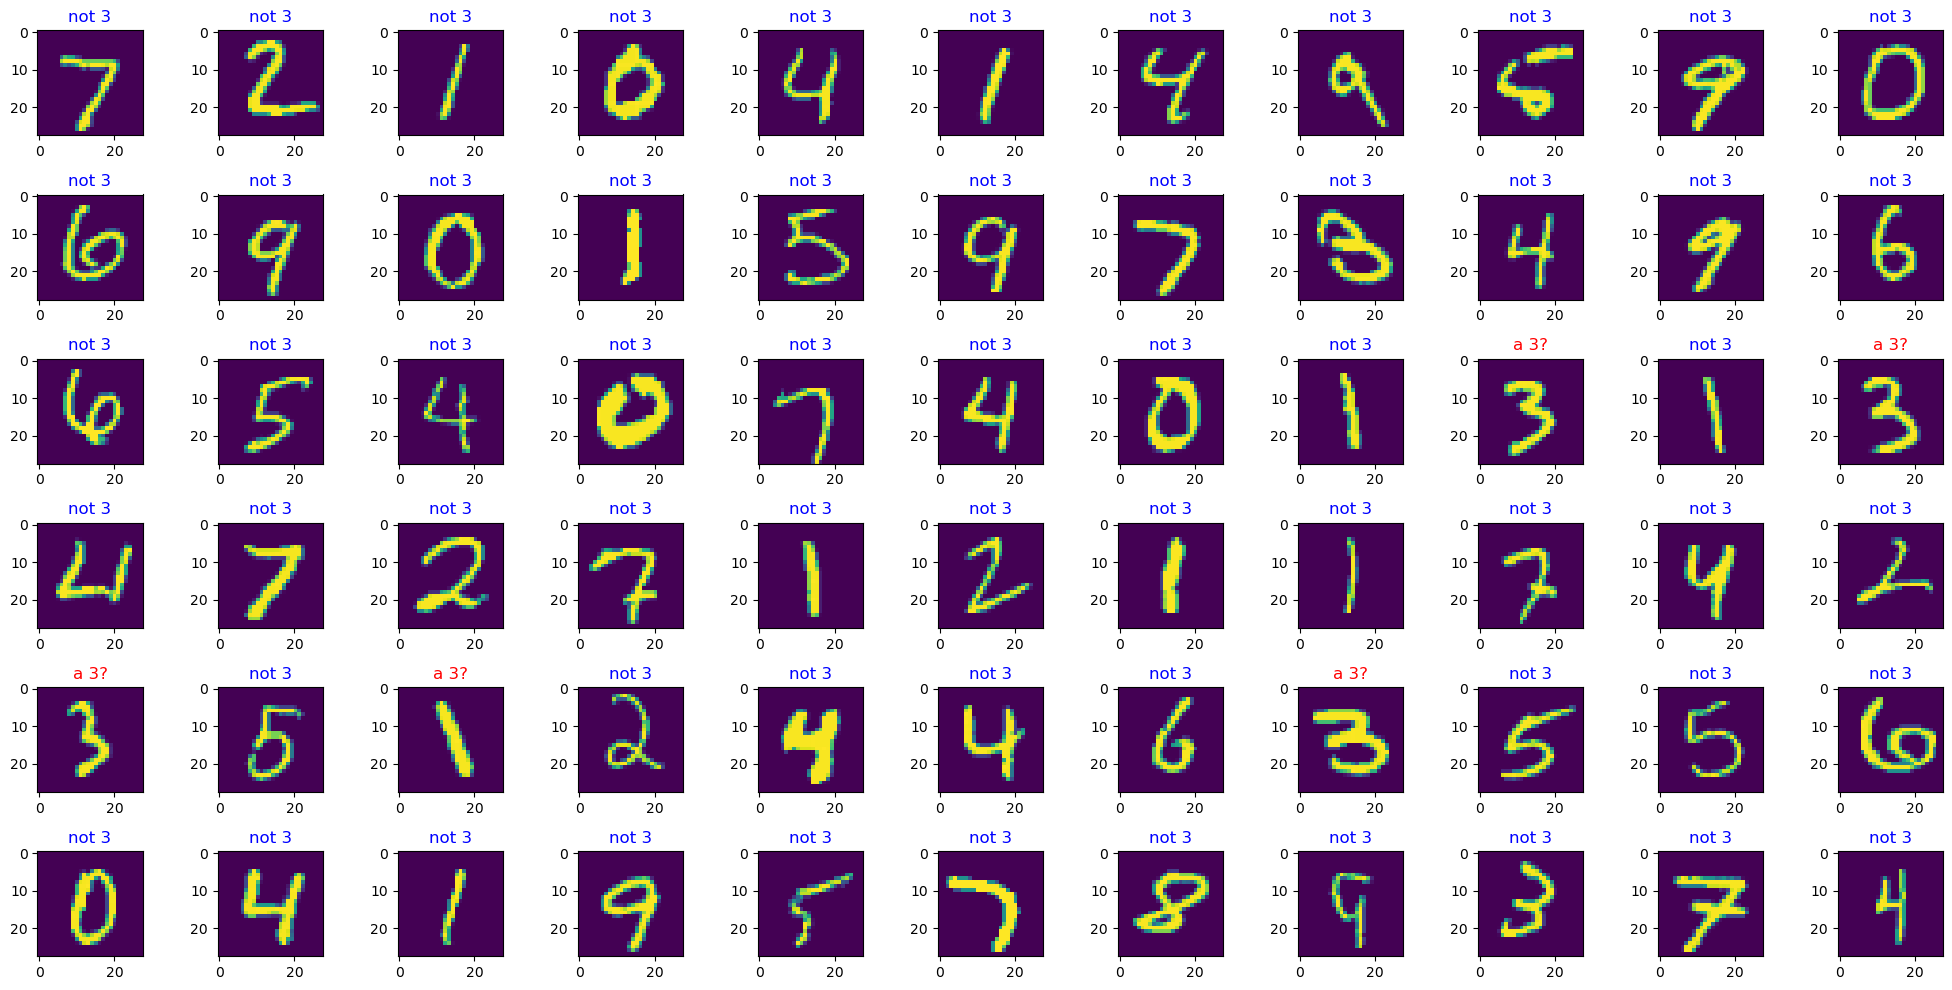

In [21]:
plt.figure(figsize=(20,10))
for i in range(66):
    plt.subplot(6,11,i+1)
    plt.imshow(x_test[i])
    plt.title('a 3?' if y_pred[i] == 1 else 'not 3', color='r' if y_pred[i] == 1 else 'b', fontsize='large')
plt.tight_layout()

Looks like it got it almost right, but not perfect.

## Performance Evaluation

Let's look at some performance measures like we've seen in class.

In [22]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

A confusion matrix tells us the True Positives, False Positives, False Negatives and True Negatives

|                    | Real Positive | Real Negative |
|:------------------ |:--------------| :-------------:|
| **Predicted Positive** | True Positive | *False* Positive |
| **Predicted Negative** | *False* Negative |   True Negative |


In [23]:
confusion_matrix(y_test_3, y_pred)

array([[8917,   73],
       [ 146,  864]])

- Accuracy is $\frac{TP+TN}{P+N}$ - the "True Rate", proportion of correct predictions (either positive or negative).
- Precision is $\frac{TP}{TP+FP}$ - the proportion of TP to all the *predicted* positives.
- Recall is $\frac{TP}{TP+FN}$ - the proportion of TP to all the *real* positives.

So naturally we'd like to have both precision and recall to be high. 

High precision means our classifier is making more TP than FP. Low amount of FPs is desirable sometimes, in case our system needs to make very little FP mistakes (Type I error), at the expense of rejecting some samples that shouldn't be rejected.

High recall means our classifier is making more TP than FN, rejecting less "real positive" samples and correctly marking them as positive.

The F1-score is the harmonic mean between Precision and Recall and can serve as a single balanced metric to try to increase: $\frac{2TP}{2TP+FP+FN}$.

In [24]:
print("Accuracy:\t", accuracy_score(y_test_3, y_pred))
print("Precision:\t", precision_score(y_test_3, y_pred))
print("Recall:\t\t", recall_score(y_test_3, y_pred))
print("F1 score:\t", f1_score(y_test_3, y_pred))

Accuracy:	 0.9781
Precision:	 0.9220917822838848
Recall:		 0.8554455445544554
F1 score:	 0.8875192604006165


These results are not too bad, but certainly not very good. We're getting high precision but lower recall.

Remember as a baseline, the accuracy of a "silly" predictor that always predicts "False" (i.e. "Not 3") will be 90%.

And the plain logistic regression model:

In [25]:
print("Accuracy:\t", accuracy_score(y_test_3, y_pred_logreg))
print("Precision:\t", precision_score(y_test_3, y_pred_logreg))
print("Recall:\t\t", recall_score(y_test_3, y_pred_logreg))
print("F1 score:\t", f1_score(y_test_3, y_pred_logreg))

Accuracy:	 0.9782
Precision:	 0.9177215189873418
Recall:		 0.8613861386138614
F1 score:	 0.888661899897855


The two models perform similarly well, but the SGD took x10 less time to converge.

**Precision and Recall are at a tradeoff.** 

If we want to get less FPs (increasing Precision) by increasing our detection threshold and only return those predictions of which we are absolutely sure, we will suffer by rejecting more "real positive"s and thus getting more FNs (decreasing Recall).

The `SGDClassifier` picks the best threshold it thinks should be used (over the training set).

Let's look at the threshold over the linear dot-product result that the classifier applies in making a decision, this time over the **Test Set**. The threshold has a direct effect on our precision and recall.

In [26]:
y_scores = logreg_sgd.decision_function(x_test.reshape(-1, 784)) # raw scores

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test_3, y_scores)

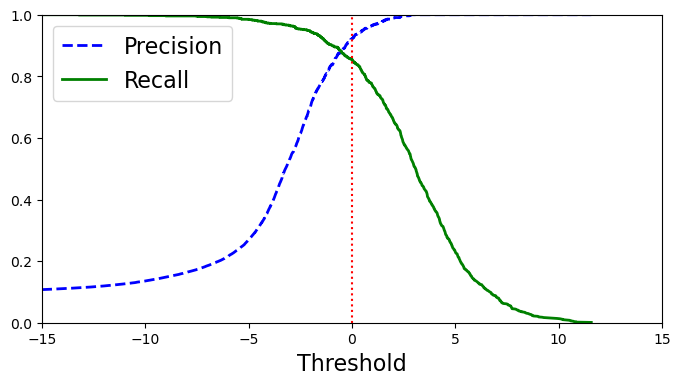

In [28]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel("Threshold", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.plot([0, 0], [0, 1], "r:")

plt.ylim([0, 1])
plt.xlim([-15, 15])
plt.show()

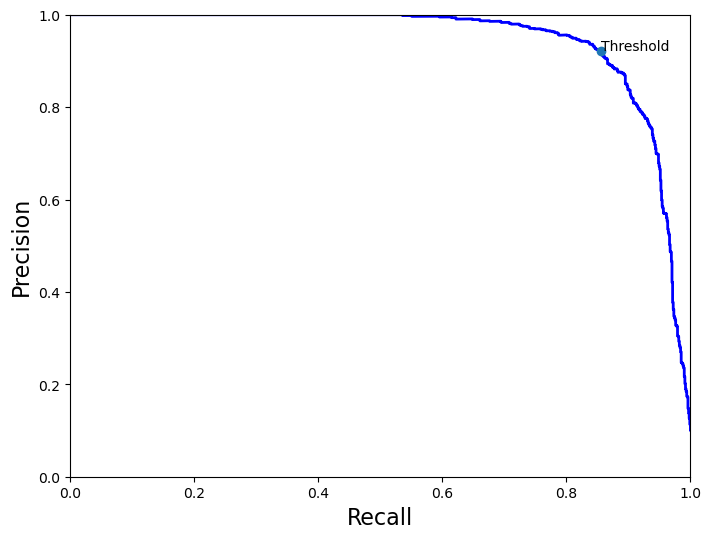

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
threshold_pos = np.searchsorted(thresholds, 0)
thresh_point = (recalls[threshold_pos], precisions[threshold_pos])
plt.plot(thresh_point[0], thresh_point[1], 'o')
plt.annotate("Threshold", xy=thresh_point)
plt.axis([0, 1, 0, 1])
plt.show()

## Overfitting and Underfitting

Let's examine the learning curves of the SGD predictor as it progressively trains on the training set.

In [30]:
# get a fresh logistic regression classifier
logreg_sgd = SGDClassifier(loss='log_loss', max_iter=1, random_state=42, penalty=None)

Taking a batch size of 1024 samples, we feed the data one batch at a time allowing the learner to update its weights. We measure the loss and accuracy.

Repeat this process for 20 "Epochs" - an Epoch (usually) is a single run over the entire dataset.

In [31]:
from sklearn.metrics import log_loss

BATCH_SIZE = 1024
num_batches = x_train.shape[0]//BATCH_SIZE

train_avg_loss = []
val_loss = []
val_acc = []
train_losses = []
for ei in range(20):
    for bi in range(num_batches):
        start_idx, end_idx = bi*BATCH_SIZE, (bi+1)*BATCH_SIZE
        x_batch = x_train[start_idx:end_idx].reshape(-1,784)
        y_batch = y_train_3[start_idx:end_idx]

        logreg_sgd.partial_fit(x_batch, y_batch, classes=[0,1])

        train_losses.append(log_loss(y_batch, logreg_sgd.predict(x_batch)))
            
        y_pred = logreg_sgd.predict(x_test.reshape(-1,784))
        val_loss.append(log_loss(y_test_3, y_pred))
        val_acc.append(accuracy_score(y_test_3, y_pred))

    print("EPOCH %d"%ei)

EPOCH 0
EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
EPOCH 17
EPOCH 18
EPOCH 19


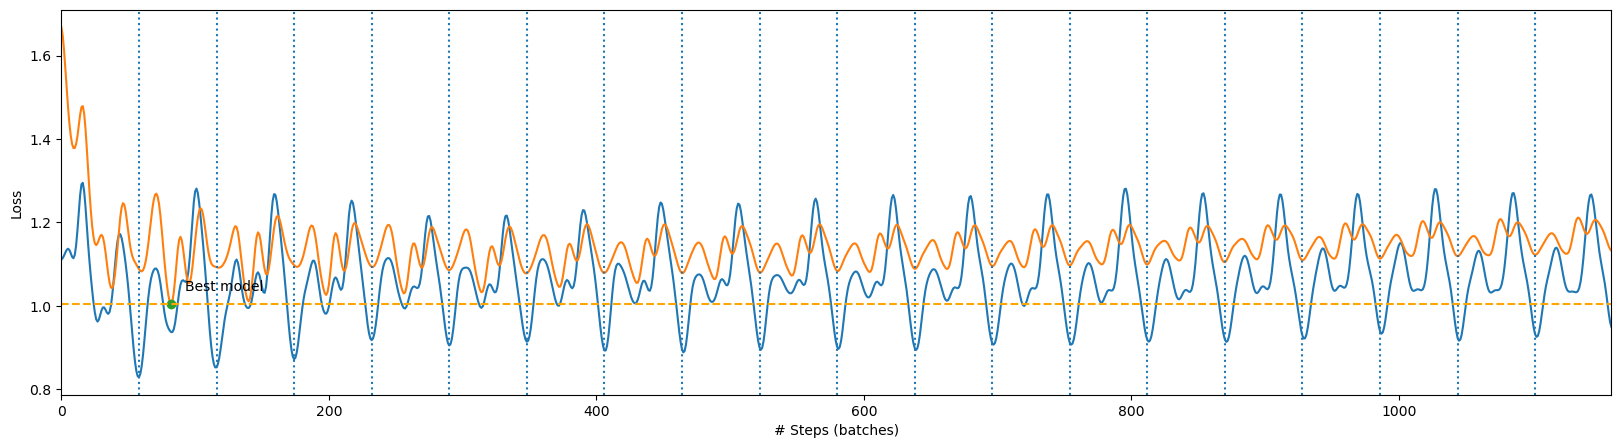

In [32]:
from scipy.ndimage import gaussian_filter1d

smooth_val_loss = gaussian_filter1d(val_loss, sigma=3)
smooth_train_loss = gaussian_filter1d(train_losses, sigma=3)
plt.plot(smooth_train_loss, label='Train loss')
plt.plot(smooth_val_loss, label='Validation loss')
for i,v in enumerate(np.arange(0,len(val_loss),x_train.shape[0]//BATCH_SIZE)[1:]):
    plt.axvline(v, linestyle=':', label='Epoch %d'%(i+1))
plt.xlabel('# Steps (batches)')
plt.ylabel('Loss')
plt.xlim(0, len(val_loss)-1)
best_model_step = np.argmin(smooth_val_loss)
best_model_pt = (best_model_step,smooth_val_loss[best_model_step])
plt.plot(best_model_pt[0], best_model_pt[1], 'o')
plt.annotate('Best model', xy=best_model_pt, xytext=(10,10), textcoords='offset points')
plt.axhline(y=best_model_pt[1], linestyle="--", color='orange', label='Best val loss')
# plt.legend();

This looks like some overfitting. There's a gap between the validation loss and the training loss.

Beyond the best model point the **validation loss is increasing**, therefore **overfitting**.

Before the best model point the **validation loss is decreasing**, therefore **underfitting**.

The `SGDClassifier` has an early stopping option to combat overfitting.

---

## Here comes your part: A Harder Problem

MNIST is a very very simple dataset that even underpowered linear models can do extremely well on. 
Let's take on a harder dataset: Cats vs. Dogs (as taken from the CIFAR-10 dataset)

Natural images are notoriously hard to wrangle. The objects appear under so many varying conditions of: lighting, shape, size, texture, deformation, angle, noise, and so on. This immense variance is difficult for simple models, but hopefully we can find a model that will produce reasonable results.

The images are just $32\times 32$ pixels with 3 channels (RGB), which is 3,072 numbers for each image. But still this is much larger than the 784 pixels of MNIST, and therefore a harder problem. The higher the dimension - the harder it is to fit a (e.g. classification) function through it.

In [33]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [34]:
# indices of cats and dogs samples from the dataset (labels 3 and 5)
cats_and_dogs = np.squeeze((y_train == 3) | (y_train == 5))
cats_and_dogs_test = np.squeeze((y_test == 3) | (y_test == 5))

In [35]:
x_train_cnd = x_train[cats_and_dogs] / 255.0
# convert to 0, 1 labels for binary classification
y_train_cnd = (y_train[cats_and_dogs] == 5).astype(np.int32)
x_test_cnd = x_test[cats_and_dogs_test] / 255.0
y_test_cnd = (y_test[cats_and_dogs_test] == 5).astype(np.int32)

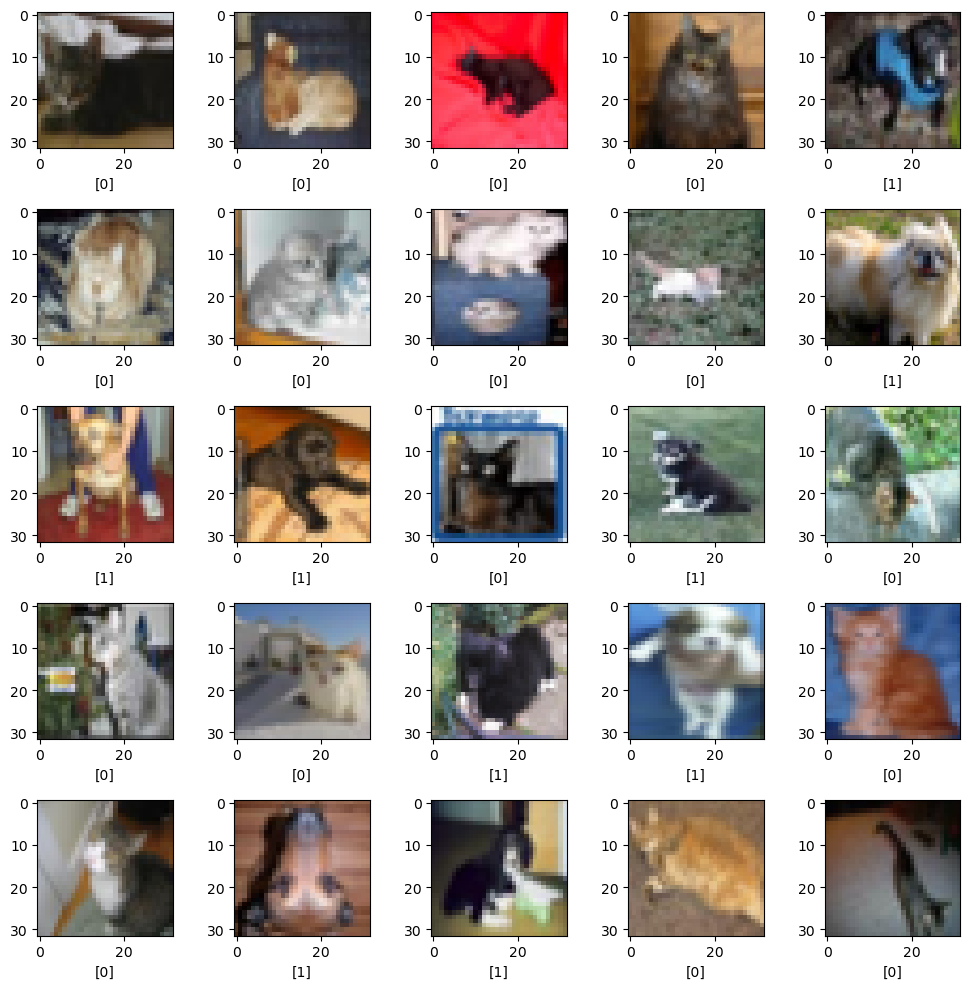

In [36]:
# show some images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.imshow(x_train_cnd[i])
    plt.xlabel(f'{y_train_cnd[i]}')
plt.tight_layout()
plt.show()

Try the SGD classifier on this dataset and evaluate its performance.

In [70]:
# train a SGD classifier with sci-kit learn's sklearn.linear_model.SGDClassifier
sgd = SGDClassifier(max_iter=1000, random_state=42)
sgd.fit(x_train_cnd.reshape(-1, 32*32*3), y_train_cnd.ravel())

SGDClassifier(random_state=42)

In [71]:
# get the predictions on the test set (x_test_cnd) using the .predict() method
preds = logreg_sgd.predict(x_test_cnd.reshape(-1, 32*32*3))
# print the confusion matrix, accuracy, and precision/recall and F1 score
print("Confusion Matrix")
print(confusion_matrix(y_test_cnd, preds))

print("Accuracy", accuracy_score(y_test_cnd, preds))
print("Precision", precision_score(y_test_cnd, preds))
print("Recall", recall_score(y_test_cnd, preds))
print("F1", f1_score(y_test_cnd, preds))

Confusion Matrix
[[565 435]
 [404 596]]
Accuracy 0.5805
Precision 0.5780795344325897
Recall 0.596
F1 0.5869030034465781


My oh my. Abysmal results.

Remember that a total random or silly classifier (e.g. one that always returns "cat") on this balanced data will have an accuracy of 50%.

It seems that a plain linear model is not cut out for this job.

Let's use a neural network. A multi-layered perceptron.

In [72]:
# train a multi layer perceptron with sci-kit learn's sklearn.neural_network.MLPClassifier
# we use 3 hidden layers with 50, 50, and 20 neurons respectively, a fairly big model with ~50k parameters
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(hidden_layer_sizes=(50, 50, 20), max_iter=1000, random_state=42)
nn.fit(x_train_cnd.reshape(-1, 32*32*3), y_train_cnd.ravel())

MLPClassifier(hidden_layer_sizes=(50, 50, 20), max_iter=1000, random_state=42)

In [73]:
# predict, and print the confusion matrix, accuracy, and precision/recall and F1 score
preds = nn.predict(x_test_cnd.reshape(-1, 32*32*3))
# print the confusion matrix, accuracy, and precision/recall and F1 score
print("Confusion Matrix")
print(confusion_matrix(y_test_cnd, preds))

print("Accuracy", accuracy_score(y_test_cnd, preds))
print("Precision", precision_score(y_test_cnd, preds))
print("Recall", recall_score(y_test_cnd, preds))
print("F1", f1_score(y_test_cnd, preds))

Confusion Matrix
[[590 410]
 [368 632]]
Accuracy 0.611
Precision 0.6065259117082533
Recall 0.632
F1 0.6190009794319294


Even a fairly large multi layered perceptron network is no match for this difficult dataset.

Let's try a convolutional approach and see if we fare better.

---
## Convolutions

Let's explore convolutions as method for visual learning. Here is some starting code, and below would be your parts to implement.

Define the simplest convolutional model, with just a single "layer" that has just a single convolution, without activation (e.g. "linear").

In [41]:
from keras.layers import Conv2D

inputs = keras.layers.Input(shape=(32, 32, 3))
conv_layer = Conv2D(1, (3,3), activation='linear', padding='same')(inputs)
model = keras.Model(inputs, conv_layer)

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 1)         28        
                                                                 
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


There are 28 parameters: 27 for the $3\times3$ kernel $\times3$ channels + 1 bias.

Here we set the convolution filter to be a "box filter" - all 1s.

In [43]:
model.layers[1].set_weights([np.expand_dims(np.array([[[1,1,1],[1,1,1],[1,1,1]],
                                                     [[1,1,1],[1,1,1],[1,1,1]],
                                                     [[1,1,1],[1,1,1],[1,1,1]]]),axis=-1),np.array([1])])

The result is, as expected, a blurred version of the input. Remember, the convolution will "mash together" the 3 input layers to a single output "activation map".

1/1 [==============================] - 0s 36ms/step


2023-04-12 08:59:14.790084: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


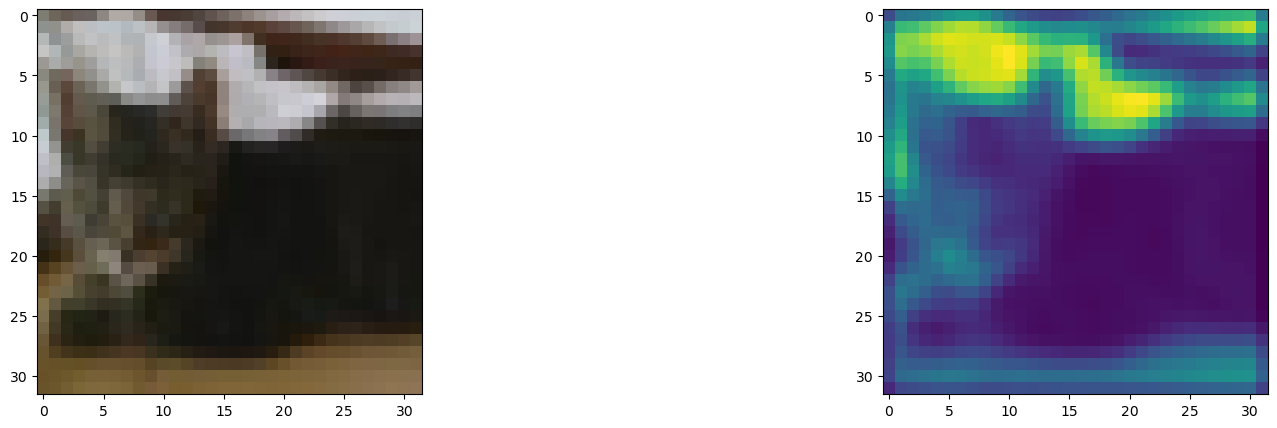

In [44]:
plt.subplot(1,2,1)
plt.imshow(x_train_cnd[0])
plt.subplot(1,2,2)
plt.imshow(model.predict(np.expand_dims(x_train_cnd[0], axis=0))[0,:,:,0]);

By setting a bigger stride we can reduce spatial resolution. The `padding` setting can be set to 'same' for 0-padding so the output has the same resolution (given a stride of 1), while 'valid' will not apply any padding and therefore will reduce the resolution by 1 pixel from each side (in a 3x3 convolution).

In [45]:
conv_layer = Conv2D(1, (3,3), activation='linear', padding='valid', strides=(2, 2))(inputs)
model = keras.Model(inputs, conv_layer)

1/1 [==============================] - 0s 19ms/step


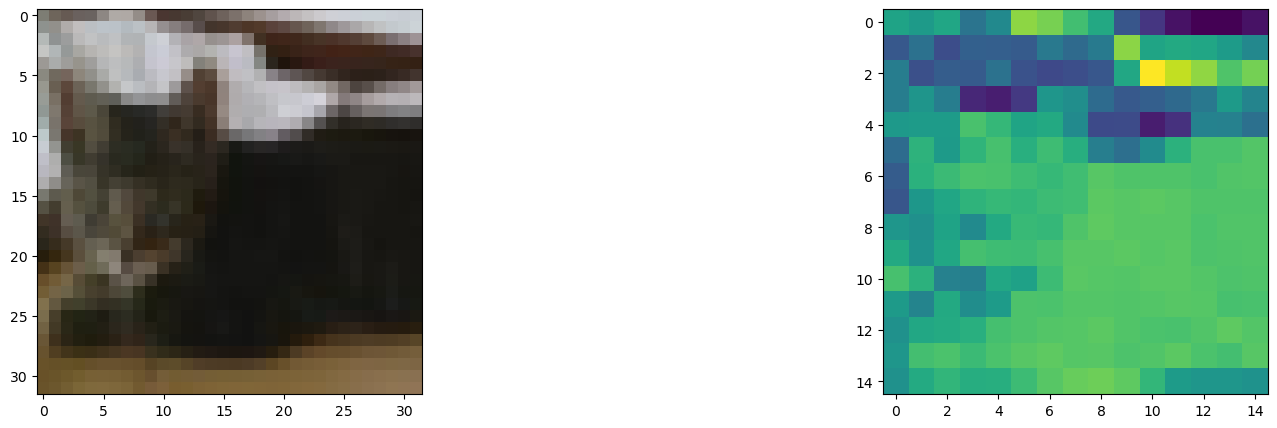

In [46]:
plt.subplot(1,2,1)
plt.imshow(x_train_cnd[0])
plt.subplot(1,2,2)
plt.imshow(model.predict(np.expand_dims(x_train_cnd[0], axis=0))[0,:,:,0]);

The stride=2 made the output shrink roughly by a factor of 2. You can try different options on the convolutional layer to see how they affect things.

1/1 [==============================] - 0s 19ms/step


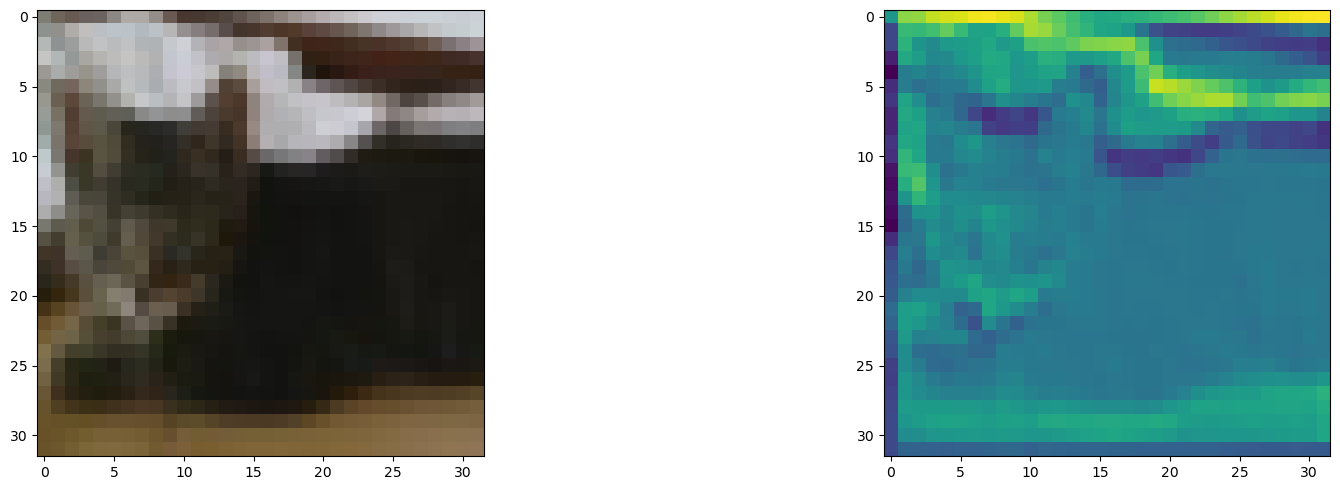

In [47]:
# for example a 'valid' padding will not produce an output for the first and last row and column
conv_layer = Conv2D(1, (3,3), activation='linear', padding='same', strides=(1, 1))(inputs)
model = keras.Model(inputs, conv_layer)
plt.subplot(1,2,1); plt.imshow(x_train_cnd[0])
plt.subplot(1,2,2); plt.imshow(model.predict(np.expand_dims(x_train_cnd[0], axis=0))[0,:,:,0])
plt.tight_layout()

1/1 [==============================] - 0s 24ms/step


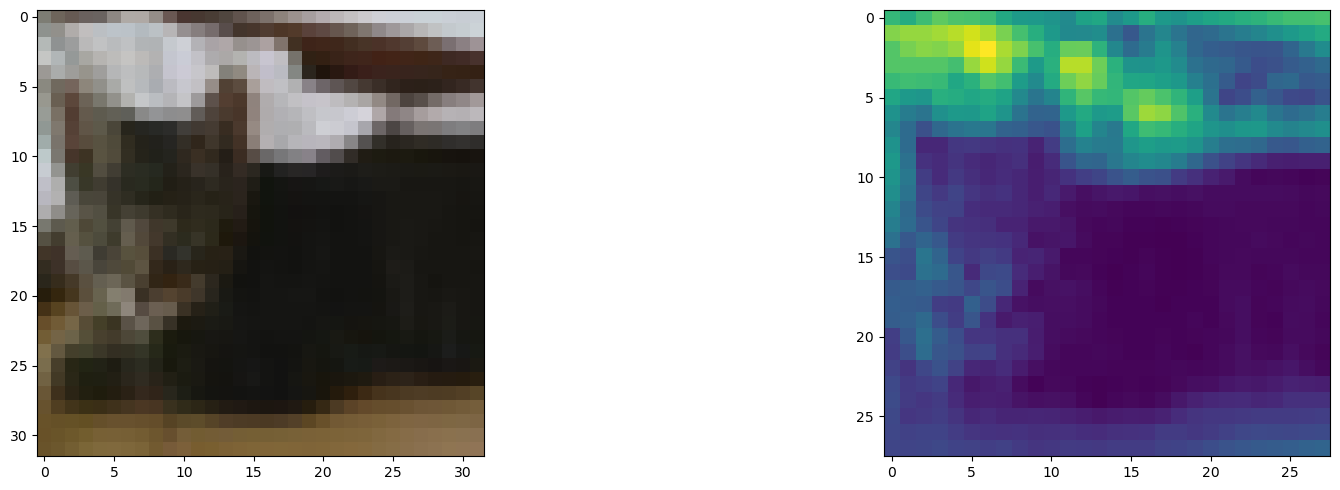

In [48]:
# for example a 'dilated' convolution will 'explode' the convolution kernel to produce a larger receptive field
# dilated convolution is also known as "atrous" convolution, and was a key component of the DeepLab architecture
# and also the original FCN architecture, very widely successful works that are still used today.
# https://arxiv.org/abs/1511.07122, http://openaccess.thecvf.com/content_cvpr_2015/html/Long_Fully_Convolutional_Networks_2015_CVPR_paper.html 
conv_layer = Conv2D(1, (3,3), activation=None, padding='valid', strides=(1, 1), dilation_rate=2)(inputs)
model = keras.Model(inputs, conv_layer)
plt.subplot(1,2,1); plt.imshow(x_train_cnd[0])
plt.subplot(1,2,2); plt.imshow(model.predict(np.expand_dims(x_train_cnd[0], axis=0))[0,:,:,0])
plt.tight_layout()

Let's try some different filters for the R,G,B channels

In [49]:
conv_layer = Conv2D(3, (3,3), activation='linear', padding='valid', strides=(1, 1))(inputs)
model = keras.Model(inputs, conv_layer)

model.layers[1].set_weights([np.array([
        # a vertical edge detector
        [[[-1,0,1],[-2,0,2],[-1,0,1]], [[-1,0,1],[-2,0,2],[-1,0,1]], [[-1,0,1],[-2,0,2],[-1,0,1]]], 
        # a horizontal edge detector
        [[[-1,-1,-1],[0,0,0],[1,1,1]], [[-1,-1,-1],[0,0,0],[1,1,1]], [[-1,-1,-1],[0,0,0],[1,1,1]]],
        # a laplacian edge detector
        [[[0,1,0],[1,4,1],[0,1,0]], [[0,1,0],[1,4,1],[0,1,0]], [[0,1,0],[1,4,1],[0,1,0]]]
    ]).T, np.array([1,1,1])])

1/1 [==============================] - 0s 20ms/step


(<Axes: >, <matplotlib.image.AxesImage at 0x297507f40>)

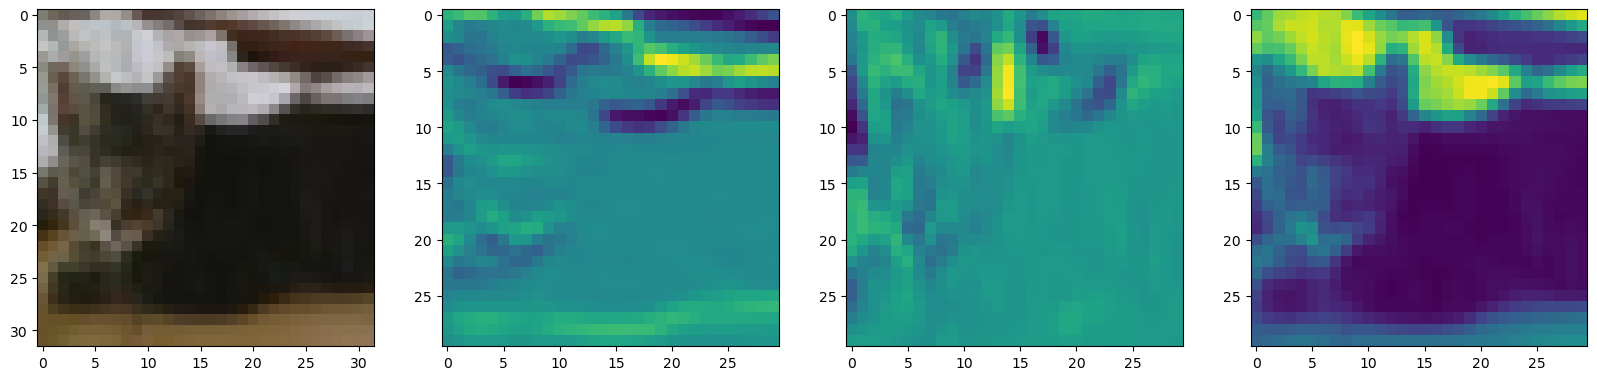

In [50]:
out = model.predict(np.expand_dims(x_train_cnd[0], axis=0))
plt.subplot(1,4,1),plt.imshow(x_train_cnd[0])
plt.subplot(1,4,2),plt.imshow(out[0,:,:,0])
plt.subplot(1,4,3),plt.imshow(out[0,:,:,1])
plt.subplot(1,4,4),plt.imshow(out[0,:,:,2])

The convolutional model can apply many transformations to the image in a single layer. It can detect edges, blobs and more, just like we've seen in class. However the true power of learned convolutions is that we don't have to supply the models with any bias, the convolutions will be learned from the data and will be optimized to solve the problem at hand.

----
# Here comes your part

Complete all the code parts that need your attention. 

You have example results from my implementation however don't expect to get precisely the same results as there's often randomness in the process. As long as your results achieve the goal with reasonable accuracy, and follow the instruction - you will get full marks.

## Classification with a Convolutional Neural Network
Define a simple convolutional model to handle our cats vs. dogs binary classification problem.

In [160]:
'''
Create a convolutional neural network model to classify the cats and dogs images.
Use the following architecture:
    - Convolutional layer with 16 filters of size (5,5), padding='same', activation='relu'
    - MaxPool layer with pool size (2,2)
    - BatchNormalization layer
    - Convolutional layer with 20 filters of size (3,3), padding='same', activation='relu'
    - MaxPool layer with pool size (2,2)
    - BatchNormalization layer
    - Convolutional layer with 20 filters of size (3,3), padding='same', activation='relu'
    - MaxPool layer with pool size (2,2)
    - BatchNormalization layer
    - GlobalAveragePooling layer
    - Dense layer with 1 unit and activation='sigmoid'

Find the layers in the Keras documentation: https://keras.io/layers/core/
You'll need an keras.layers.Input layer with shape (32, 32, 3), and a keras.Model as well.
'''

from keras.layers import Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Dense

def make_classification_model():
    inputs = keras.layers.Input(shape=(32, 32, 3), name='input')
    conv_layer = Conv2D(16, (5,5), padding='same', activation='relu', name='conv1')(inputs)
    maxpool_layer = MaxPool2D(pool_size=(2,2), name='maxp1')(conv_layer)
    batchnorm_layer = BatchNormalization(name='bn1')(maxpool_layer)
    conv_layer = Conv2D(20, (3,3), padding='same', activation='relu', name='conv2')(batchnorm_layer)
    maxpool_layer = MaxPool2D(pool_size=(2,2), name='maxp2')(conv_layer)
    batchnorm_layer = BatchNormalization(name='bn2')(maxpool_layer)
    conv_layer = Conv2D(20, (3,3), padding='same', activation='relu', name='conv3')(batchnorm_layer)
    maxpool_layer = MaxPool2D(pool_size=(2,2), name='maxp3')(conv_layer)
    batchnorm_layer = BatchNormalization(name='bn3')(maxpool_layer)
    globalavgpool_layer = GlobalAveragePooling2D(name='gavgpool')(batchnorm_layer)
    dense_layer = Dense(1, activation='sigmoid', name='dense')(globalavgpool_layer)
    model = keras.Model(inputs, dense_layer, name='model')
    return model

In [161]:
model = make_classification_model()

#### What does the model look like?

In [162]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 16)        1216      
                                                                 
 maxp1 (MaxPooling2D)        (None, 16, 16, 16)        0         
                                                                 
 bn1 (BatchNormalization)    (None, 16, 16, 16)        64        
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 20)        2900      
                                                                 
 maxp2 (MaxPooling2D)        (None, 8, 8, 20)          0         
                                                                 
 bn2 (BatchNormalization)    (None, 8, 8, 20)          80    

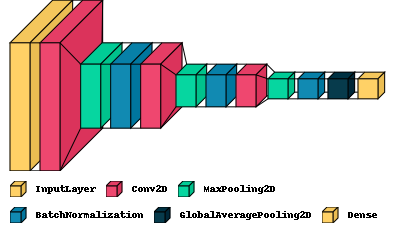

In [163]:
import visualkeras
visualkeras.layered_view(model, legend=True)

#### Training the model

In [164]:
# compile the model with an 'adam' optimizer and 'binary_crossentropy' loss, and track 'accuracy' as the metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# train the model for 20 epochs, with a batch size of 32, and validate on the test set (x_test_cnd, y_test_cnd)
history = model.fit(x_train_cnd, y_train_cnd, epochs=20, batch_size=32, validation_data=(x_test_cnd, y_test_cnd))

Epoch 1/20
313/313 [==============================] - 3s 8ms/step - loss: 0.6568 - accuracy: 0.6096 - val_loss: 0.6572 - val_accuracy: 0.6195
Epoch 2/20
313/313 [==============================] - 2s 8ms/step - loss: 0.6154 - accuracy: 0.6636 - val_loss: 0.6297 - val_accuracy: 0.6350
Epoch 3/20
313/313 [==============================] - 2s 8ms/step - loss: 0.5878 - accuracy: 0.6884 - val_loss: 0.7029 - val_accuracy: 0.6000
Epoch 4/20
313/313 [==============================] - 2s 8ms/step - loss: 0.5648 - accuracy: 0.7048 - val_loss: 0.5857 - val_accuracy: 0.6805
Epoch 5/20
313/313 [==============================] - 2s 8ms/step - loss: 0.5492 - accuracy: 0.7177 - val_loss: 0.5441 - val_accuracy: 0.7205
Epoch 6/20
313/313 [==============================] - 2s 8ms/step - loss: 0.5284 - accuracy: 0.7367 - val_loss: 0.5647 - val_accuracy: 0.7150
Epoch 7/20
313/313 [==============================] - 2s 8ms/step - loss: 0.5138 - accuracy: 0.7475 - val_loss: 0.6010 - val_accuracy: 0.6940
Epoch 

### Learning curves and evaluation

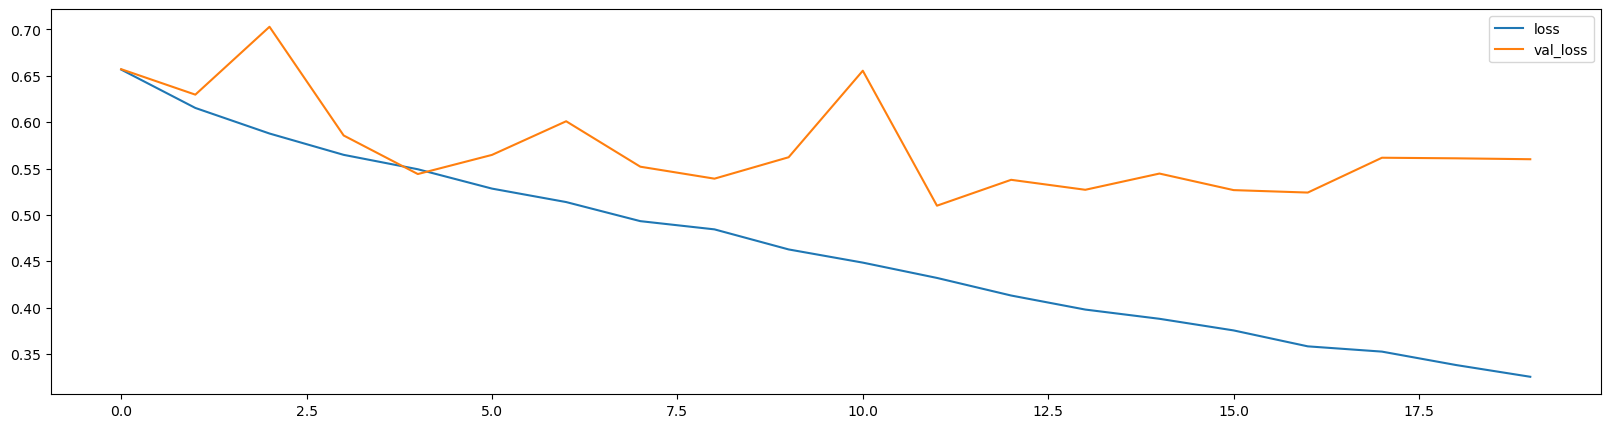

In [165]:
# show the history of the training
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

There are clear signs of overfitting, but the validation loss is still decreasing. You can train the model further to see if you can squeeze out some extra performance.

In [166]:
# get predictions for the test set
y_pred = model.predict(x_test_cnd)

63/63 [==============================] - 0s 3ms/step


In [167]:
# print the confusion matrix, accuracy, and precision/recall and F1 score
print("Confusion Matrix")
print(confusion_matrix(y_test_cnd, y_pred > 0.5))

print("Accuracy", accuracy_score(y_test_cnd, y_pred > 0.5))
print("Precision", precision_score(y_test_cnd, y_pred > 0.5))
print("Recall", recall_score(y_test_cnd, y_pred > 0.5))
print("F1", f1_score(y_test_cnd, y_pred > 0.5))

Confusion Matrix
[[750 250]
 [284 716]]
Accuracy 0.733
Precision 0.7412008281573499
Recall 0.716
F1 0.728382502543235


The convolutional model definitely did much better. But we can see clear signs of overfitting: a big gap between train and validation loss.

Visualize some of the results

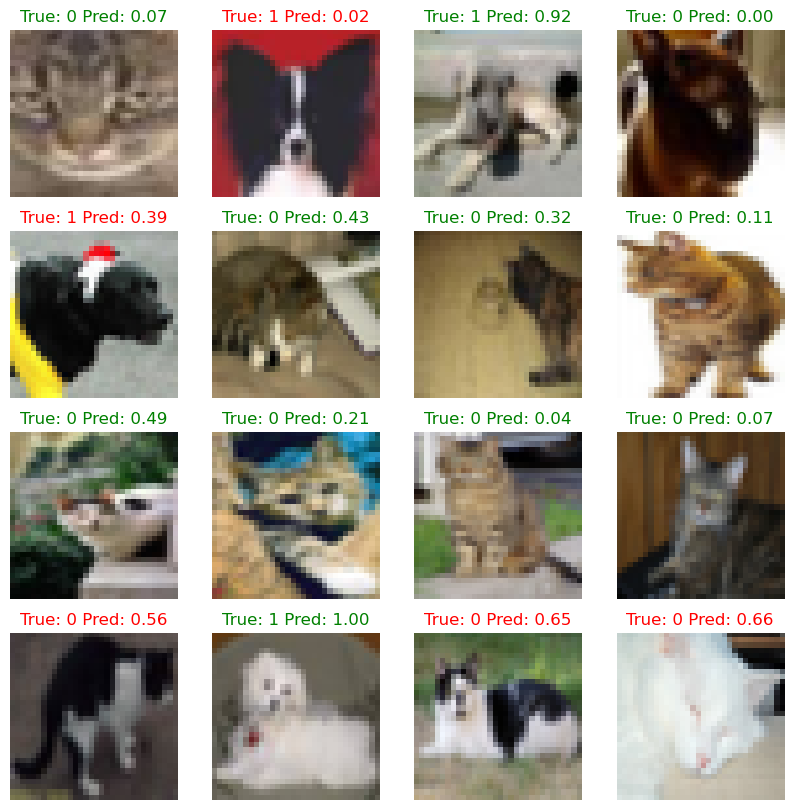

In [168]:
# show some predictions on the test set
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    # pick a random image from the test set
    im_idx = np.random.randint(0, len(x_test_cnd))
    plt.imshow(x_test_cnd[im_idx])
    plt.title("True: %d Pred: %.2f" % (y_test_cnd[im_idx], y_pred[im_idx]), color='green' if y_test_cnd[im_idx]==(y_pred[im_idx]>0.5) else 'red')
    plt.axis('off')

### Visualize the activations

We can run only parts of the model to get just the activation at e.g. the 3rd convolutional layer.

dict_keys(['input', 'conv1', 'maxp1', 'bn1', 'conv2', 'maxp2', 'bn2', 'conv3', 'maxp3', 'bn3', 'gavgpool', 'dense'])
1/1 [==============================] - 0s 10ms/step


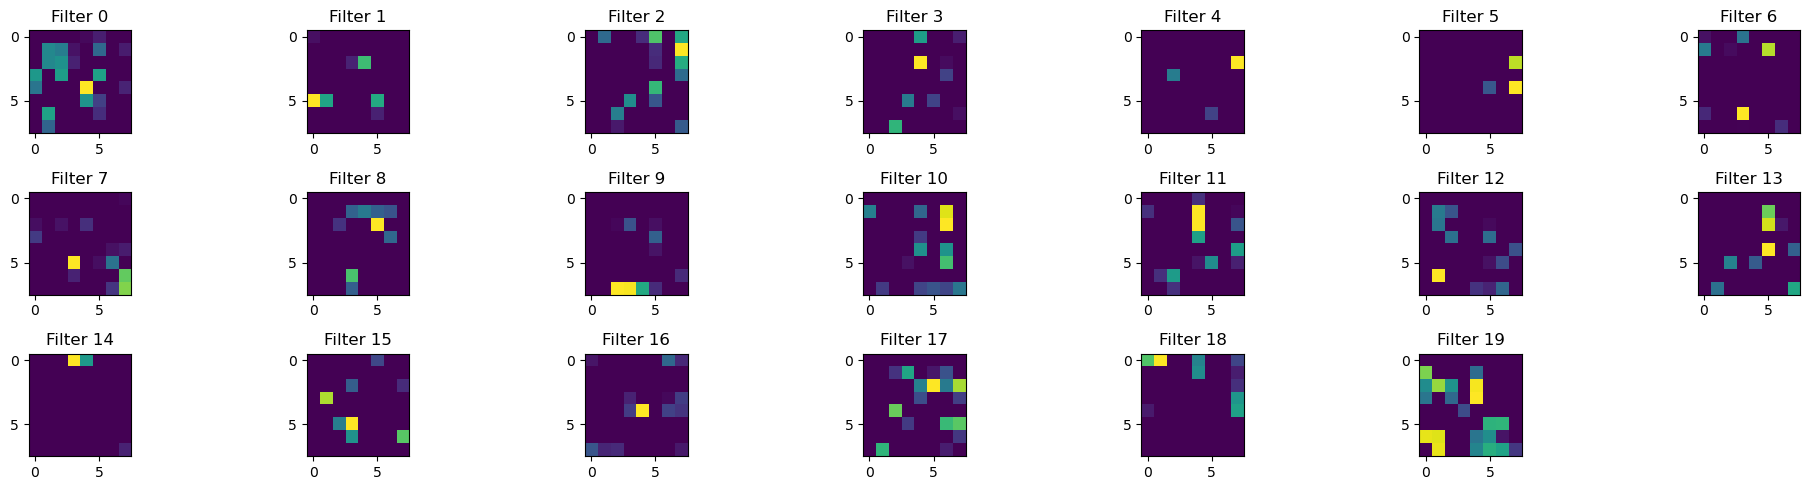

In [169]:
# a dictionary mapping layer names to the layer objects
layer_dict = dict([(layer.name, layer) for layer in model.layers])

print(layer_dict.keys())

# use the Model API to create a new model that outputs the activations of the `conv3` layer
# just use keras.models.Model(...) and pass the inputs and outputs you require
# in this case - the inputs are the original model inputs (model.inputs[0]), and the outputs are the 
# activations of the `conv3` layer, e.g. layer_dict['conv3'].output.
# run it on a single image from the test set (e.g. x_test_cnd[0:1]) to get the activations tensor.
# remember that the model expects a batch of images, so we either need to add a dimension using 
# `np.expand_dims` on axis 0, or use the [0:1] trick to get a batch of size 1
# finally, show the activation maps of 20 filters in the `conv3` layer.
# you can use plt.subplot to show them in a grid, and plt.imshow to show the activation maps.
# you can use plt.tight_layout() to make sure the images are not too close to each other.
# the activations should be of shape (1, 7, 7, 20)

activation_model = keras.models.Model(inputs=model.inputs[0], outputs=layer_dict['conv3'].output)
for i in range(20):
    plt.subplot(3,7,i+1)
    activations = activation_model.predict(x_test_cnd[0:1])
    plt.imshow(activations[0,:,:,i])
    plt.title("Filter %d" % i)
plt.tight_layout()

### Visualize the "class activation map"

The Class Activation Map method is actually a very useful tool.
Not ony can we learn about how our networks work, we can use it to locate objects (we will see about that soon).
You will see in the examples below that it can tell us "what's the most important information for the network to make its decision".
So in our case of cats and dogs we will see: ears, tails, faces, etc. light up.

The Grad-CAM paper [Selvaraju 2017](https://openaccess.thecvf.com/content_iccv_2017/html/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.html) recieved over 13,000 citations, and provides a good overview of the method. Video: https://www.youtube.com/watch?v=COjUB9Izk6E
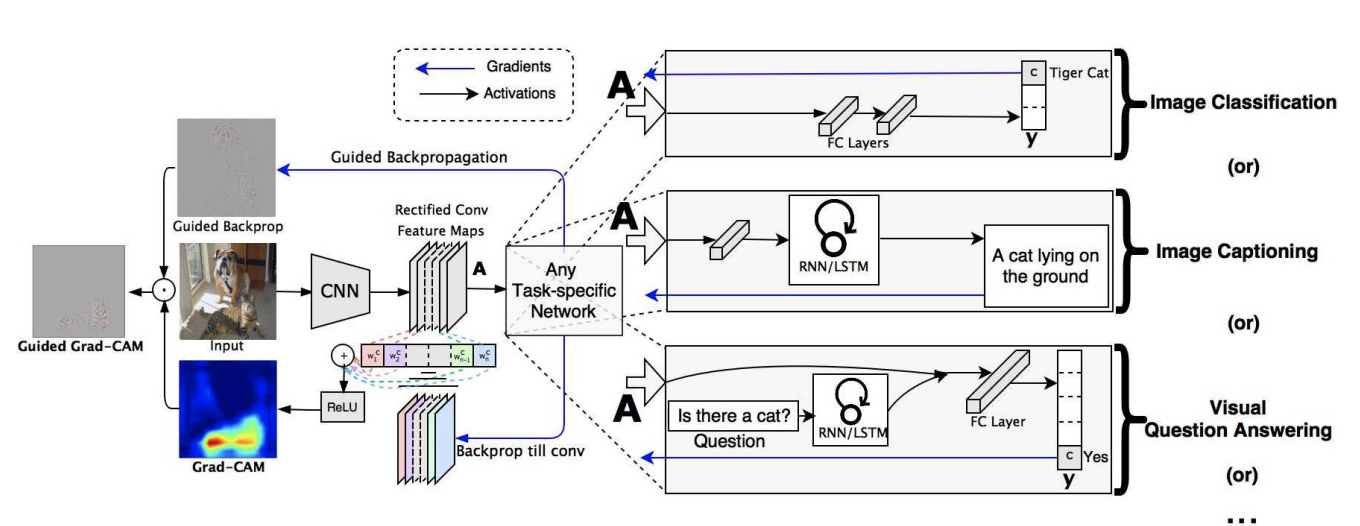

The essence of the method is in capturing the gradients that give rise to the activation of a layer given it sees an image of the class of interest.
We then backpropagate the gradients through the network all the way back to the original input domain, and project the gradients onto an image.

Implement the Grad-CAM method below. Use the tutorial from Keras to help you: https://keras.io/examples/vision/grad_cam/
The tutorial's `make_gradcam_heatmap` function should get you most of the way there.

In [170]:
# implement the Grad-CAM algorithm to visualize the activation maps of the `conv3` layer
# follow the tutorial here: https://keras.io/examples/vision/grad_cam/

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

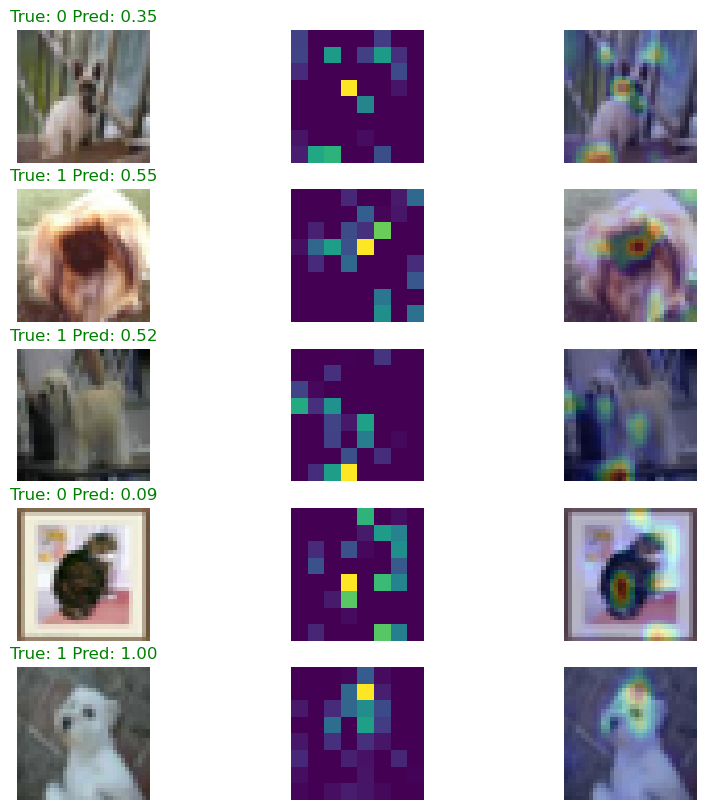

In [171]:
# for 5 samples from the dataset
# show the original image, the heatmap and heatmap (upscaled) overlaid on the original image
plt.figure(figsize=(10,10))
for i in range(5):
    im_idx = np.random.randint(0, len(x_test_cnd))
    img = x_test_cnd[im_idx]
    heatmap = make_gradcam_heatmap(np.expand_dims(x_test_cnd[im_idx], 0), model, 'conv3', pred_index=0)
    plt.subplot(5,3,1 + i*3)
    plt.imshow(img)
    y_test_cnd_ = y_test_cnd[im_idx]
    y_pred_ = y_pred[im_idx]
    plt.title("True: %d Pred: %.2f" % (y_test_cnd_, y_pred_), color='green' if y_test_cnd_==(y_pred_>0.5) else 'red')
    plt.axis('off')
    plt.subplot(5,3,2 + i*3)
    plt.imshow(heatmap)
    plt.axis('off')
    plt.subplot(5,3,3 + i*3)
    plt.imshow(img)
    plt.imshow(tf.image.resize(np.expand_dims(heatmap, -1), (32, 32)), cmap='jet', alpha=0.25)
    plt.axis('off')

### Visualize what the convolutional neurons "like"

This visualization method is again one of the best ones to understand what the network learns.
Each neuron (we would hope) would pick up on a different pattern in the image. 
The lower layers would learn simpler patterns, and the higher we go we get more complex and bigger patterns.
Putting them together (a linear combination, ..., approximately) will create the whole object.
This method was one of the first to solidify the understanding of convolutional networks as feature extractors.

The tutorial from Keras will help you implement it: https://keras.io/examples/vision/visualizing_what_convnets_learn/

A very long time ago (in AI terms at least) in 2015, Google put forth this method to explain their work on Inception.
https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html
It also created a new fad for a hot moment called "deep dream", with all the disturbing and beautiful patterns created by gradient ascent on a single neuron or layer.

Your implementation should mirror the Keras tutorial linked above.
But a few tweaks can make it much more concise and streamlined.

In [172]:
# implement the gradient ascent algorithm for visualizing filters
# follow the tutorial: https://keras.io/examples/vision/visualizing_what_convnets_learn/
# you can use the `layer_dict` dictionary from before to get the layer objects

def compute_loss(model, input_image, filter_index):
    activation = model(input_image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(model, img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(model, img, filter_index)

    # Compute gradients
    grads = tape.gradient(loss, img)

    # Normalize gradients
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[-25:25, -25:25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

def visualize_filter(model, layer_name, filter_index=None):
    layer = layer_dict[layer_name]
    feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

    iterations = 30
    learning_rate = 10.0

    img = (tf.random.uniform((1, 32, 32, 3)) - 0.5) * 0.25

    for _ in range(iterations):
        loss, img = gradient_ascent_step(feature_extractor, img, filter_index, learning_rate)

    # Decode the resulting image
    img = deprocess_image(img[0].numpy())
    return loss, img

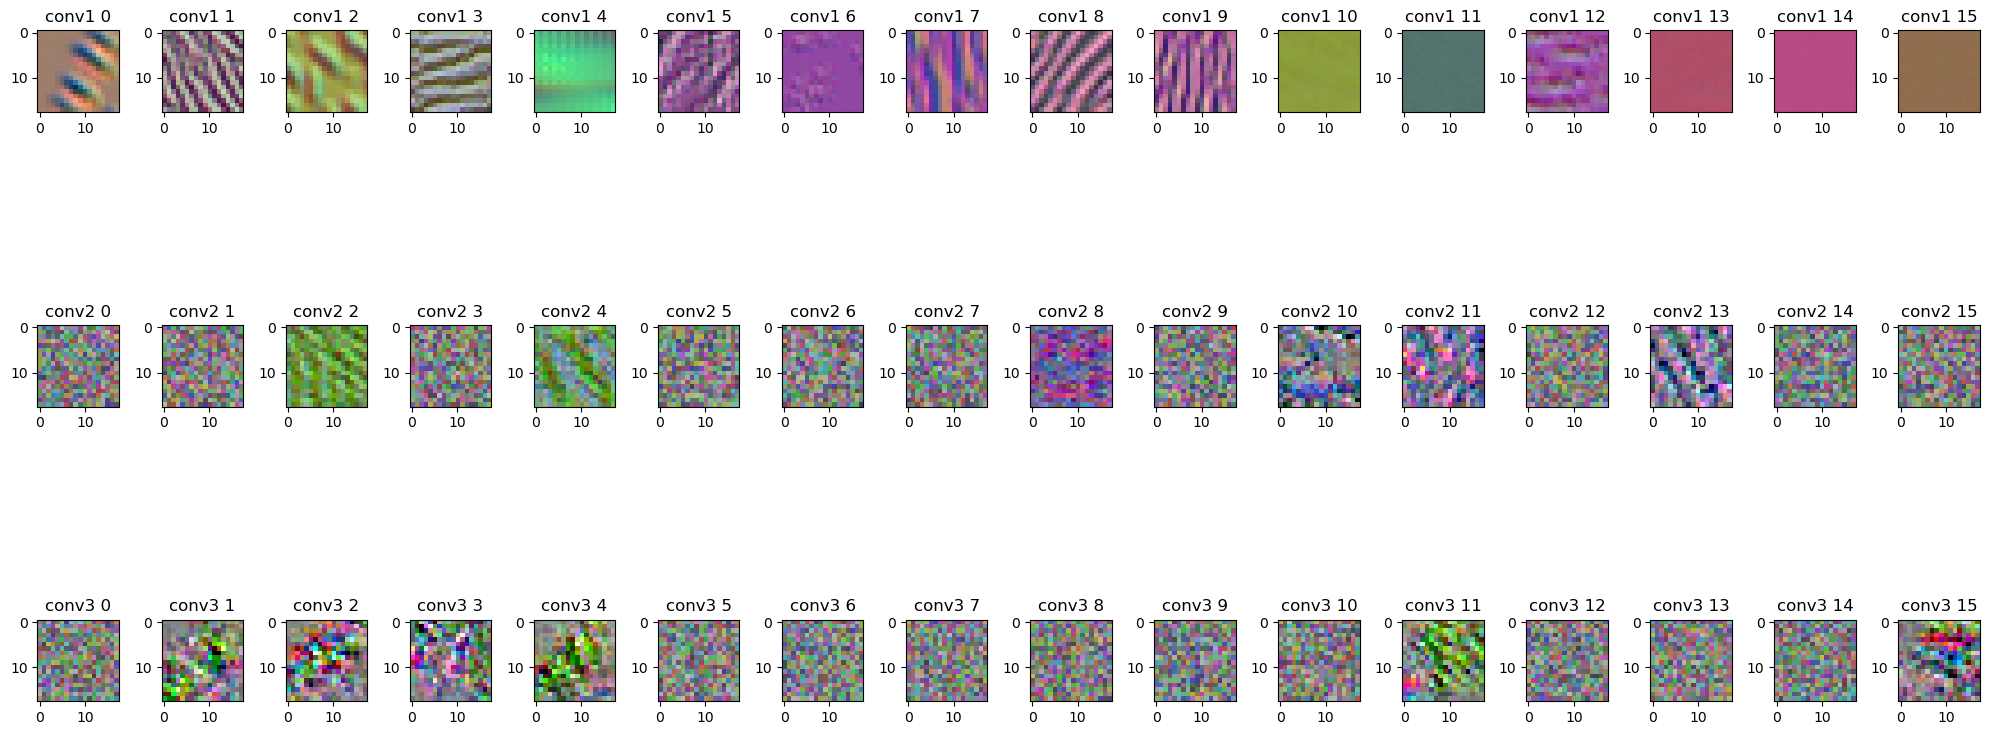

In [173]:
# visualize 10 filters from the conv1, conv2 and conv3 layers
plt.figure(figsize=(20,10))
for i in range(16):
    for j, conv_layer_name in enumerate(['conv1', 'conv2', 'conv3']):
        loss, img = visualize_filter(model, conv_layer_name, filter_index=i)
        plt.subplot(3,16,i+1 + j*16)
        plt.imshow(img)
        plt.title("%s %d"%(conv_layer_name, i))
plt.tight_layout()

We can clearly see the patterns emerge, similar to the tutorials. This means our very small simple network was indeed learning useful visual abstractions of the data.

That's a wrap!

I hope this gives you a first order understanding of convolutional neural networks and how useful they are.

We will next be looking at more sophisticated networks to perform object detection.